In [13]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lin_data(N, sigma_sq, rng):
    n1 = N//2
    n2 = N - n1
    intercept_true, slope_true = -3.0, 2.0
    x = np.concatenate([np.linspace(-10, 10, n1), np.linspace(-3.0, 2.5, n2)+0.6])
    y = slope_true * x + intercept_true + rng.normal(0, np.sqrt(sigma_sq), size=N)

    # Sort by x values for better visualization
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x, y


def generate_nonlinear_data(N, sigma_sq, rng):
    rng = np.random.default_rng(0) if rng is None else rng
    # Original data points
    n1 = N//4
    n2 = N - n1
    x_original = np.linspace(-4, 4, n1)
    y_original = 10 * (np.sin(x_original) - 0.15*x_original**2) + rng.normal(0, np.sqrt(sigma_sq), size=n1)

    # Additional data points between (-1, 1)
    x_dense = np.linspace(-1, 1, n2)
    y_dense = 10 * (np.sin(x_dense) - 0.15*x_dense**2) + rng.normal(0, np.sqrt(sigma_sq), size=n2)

    # Combine all data points
    x = np.concatenate([x_original, x_dense])
    y = np.concatenate([y_original, y_dense])

    # Sort by x values for better visualization
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x, y


def plot_gaussian_pdf(mu, Sigma, xlabel, ylabel, title, show_colorbar=True):
    # Plot 2D prior Gaussian PDF as contour plot

    xmin = mu[0] - 3*np.sqrt(Sigma[0,0])
    xmax = mu[0] + 3*np.sqrt(Sigma[0,0])
    ymin = mu[1] - 3*np.sqrt(Sigma[1,1])
    ymax = mu[1] + 3*np.sqrt(Sigma[1,1])

    theta0_grid = np.linspace(xmin, xmax, 100)
    theta1_grid = np.linspace(ymin, ymax, 100)
    Theta0, Theta1 = np.meshgrid(theta0_grid, theta1_grid)

    # Compute the 2D Gaussian PDF
    def multivariate_gaussian_pdf(theta, mu, Sigma):
        k = len(mu)
        diff = theta - mu
        return (2 * np.pi) ** (-k/2) * np.linalg.det(Sigma) ** (-1/2) * np.exp(-0.5 * diff.T @ np.linalg.inv(Sigma) @ diff)

    # Vectorized version for grid
    pdf_values = np.zeros_like(Theta0)
    for i in range(Theta0.shape[0]):
        for j in range(Theta0.shape[1]):
            theta = np.array([Theta0[i, j], Theta1[i, j]])
            pdf_values[i, j] = multivariate_gaussian_pdf(theta, mu, Sigma)

    plt.figure(figsize=(8, 6))
    contour = plt.contour(Theta0, Theta1, pdf_values, levels=10)
    # plt.contourf(Theta0, Theta1, pdf_values, levels=50, alpha=0.6, cmap='Blues')
    plt.imshow(pdf_values, extent=[theta0_grid.min(), theta0_grid.max(), theta1_grid.min(), theta1_grid.max()], 
            origin='lower', cmap='Blues', alpha=0.8)

    if show_colorbar:
        plt.colorbar(label='PDF')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_function_space_distribution(mu, Sigma, x_grid, X_grid, label, title, 
                                     xlabel='x', ylabel='y', data=None, post_pred_sigma_sq=None,
                                     n_samples_fn=0, sample_data=False, rng=None):
    mean = X_grid @ mu
    var = np.diag(X_grid @ Sigma @ X_grid.T) + (0 if post_pred_sigma_sq is None else post_pred_sigma_sq)
    std = np.sqrt(var)

    plt.figure(figsize=(10, 6))
    if data is not None:
        plt.scatter(data[0], data[1], color='black', s=20, alpha=0.7, label='Data')
    plt.plot(x_grid, mean, label=label)
    plt.fill_between(x_grid, mean - 2*std, mean + 2*std, alpha=0.2, label='±2σ')

    if n_samples_fn > 0:
        rng = np.random.default_rng() if rng is None else rng
        theta_samples = rng.multivariate_normal(mu, Sigma, n_samples_fn)
        for theta in theta_samples:
            f_samples = X_grid @ theta
            if sample_data:
                f_samples += rng.normal(0, np.sqrt(post_pred_sigma_sq), size=X_grid.shape[0])
                plt.scatter(x_grid, f_samples, alpha=0.3, s=10)
            else:
                plt.plot(x_grid, f_samples, alpha=0.3, linestyle='--')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Bayesian Linear Regression

Given data $$\mathcal{D} = \left\{ \left(\mathbf{x}^{(i)}, \, y^{(i)} \right) \right\}_{i=1}^N \quad \text{ with } \, \mathbf{x}^{(i)} \in \mathbb{R}^d, y \in \mathbb{R},$$
we assume that $$y^{(i)} = f(\mathbf{x}^{(i)}) + \varepsilon^{(i)}, \quad \varepsilon^{(i)} \sim \mathcal{N}(\varepsilon^{(i)}; 0, \sigma^2)$$
with i.i.d. $\varepsilon^{(i)}$ and *known* $\sigma^2$ (*measurement noise*).

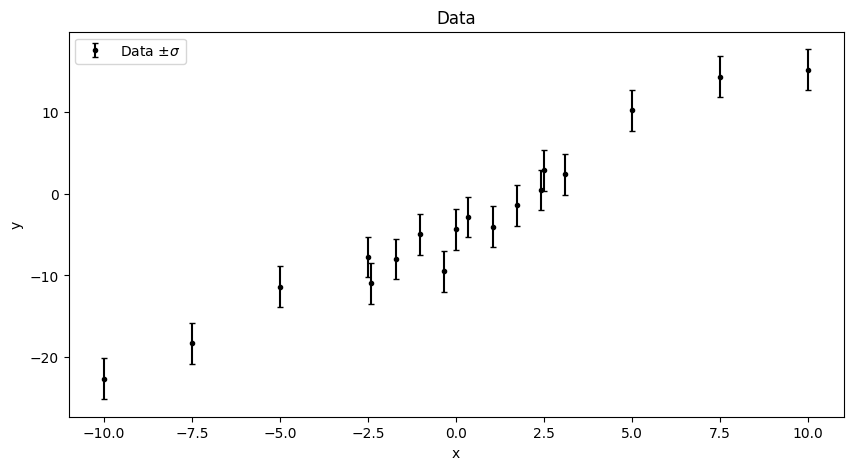

In [14]:
rng = np.random.default_rng(0)
sigma_sq = 2.5**2
x, y = generate_lin_data(N=18, sigma_sq=sigma_sq, rng=rng)

plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=np.sqrt(sigma_sq), fmt='k.', capsize=2, label=r'Data $\pm \sigma$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.legend()
plt.show()

**Goal:** We want to know $f$. Let's model it as a **linear-in-the-parameters** function: $$f(\mathbf{x}) = \phi(\mathbf{x})^\top \mathbf{\theta}$$ where $\phi: \mathbb{R}^d \to \mathbb{R}^D$ is a (possibly non-linear) *feature transformation*, and $\mathbf{\theta} \in \mathbb{R}^D$ are the *parameters* (weights).

Let $\mathbf{X} := \begin{bmatrix} \phi(\mathbf{x}^{(1)}) \\ \vdots \\ \phi(\mathbf{x}^{(N)}) \end{bmatrix}$, and $\mathbf{y} := (y^{(1)}, \dots, y^{(N)})^\top \in \mathbb{R}^N$.

In [15]:
# Feature transformation
Phi = lambda x: np.hstack([np.ones((x.shape[0],1)), x[:, None]])

# Design matrix
X = Phi(x)

## Maximum Likelihood Solution

We can write these assumptions as a Gaussian **likelihood**: $$p(\mathbf{y} \mid \theta, \mathbf{X}) := \mathcal{N}(\mathbf{y}; \mathbf{X}\theta, \sigma^2 I_N) = \frac{1}{(2\pi\sigma^2)^{N/2}} \, \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{X}\theta - \mathbf{y}\|^2_2\right)$$

Let's find $\theta^*$ such that it *maximizes* the likelihood 
$$\theta^* \in \operatorname{arg\,max}_{\theta} \, p(\mathbf{y} \mid \theta, \mathbf{X}) \quad \Leftrightarrow \quad \theta^* \in \operatorname{arg\,min}_{\theta} \, - \log p(\mathbf{y} \mid \theta, \mathbf{X})$$
which is just $$-\log p(\mathbf{y} \mid \theta, \mathbf{X}) = \frac{1}{2\sigma^2} \|\mathbf{X}\theta - \mathbf{y}\|^2_2 + \text{const.}$$
so we can just minimize the *squared error*: $$\mathcal{L}(\theta) = \| \mathbf{X} \theta - \mathbf{y} \|^2_2.$$
e.g. via the well-known **Moore-Penrose pseudoinverse**: $$\theta^* = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

MLE solution: theta* = [-3.71574881  2.02831842]


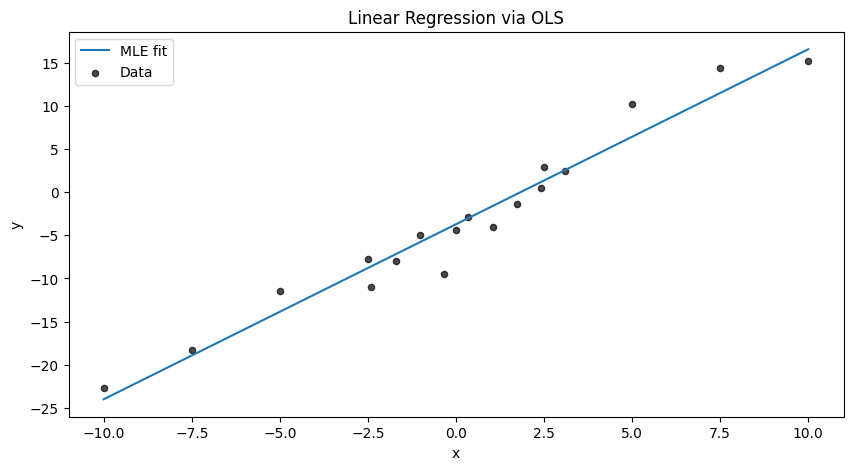

In [16]:
# Ordinary Least Squares (OLS) solution using pseudoinverse
theta_mle = np.linalg.pinv(X) @ y
print(f"MLE solution: theta* = {theta_mle}")

# plot function and data
x_grid = np.linspace(-10, 10, 200)
X_grid = Phi(x_grid)
y_grid = X_grid @ theta_mle
plt.figure(figsize=(10, 5))
plt.plot(x_grid, y_grid, label='MLE fit')
plt.scatter(x, y, color='black', s=20, alpha=0.7, label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression via OLS')
plt.legend()
plt.show()


## Question: Do you think that the point estimate $\theta^*$ are the *only plausible* parameters? 

No! We want access to *model uncertainty*!

# Prior


Let's be **Bayesian** about this and place a **Gaussian prior** on $\theta$: $$p(\mathbf{\theta}) := \mathcal{N}(\mathbf{\theta}; \mathbf{\mu}, \Sigma)$$

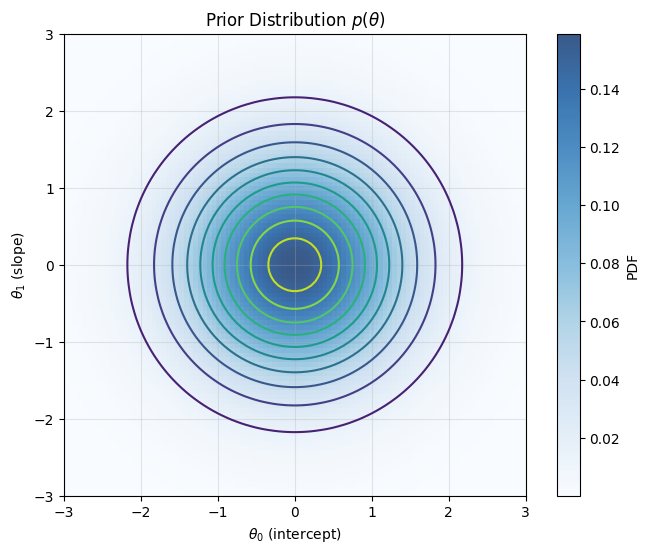

In [17]:
# Prior on theta
mu = np.zeros(2)         # prior mean on theta
Sigma = np.eye(2) * 1.    # prior covariance
Sigma_inv = np.linalg.inv(Sigma)

plot_gaussian_pdf(mu, Sigma, r'$\theta_0$ (intercept)', r'$\theta_1$ (slope)', r'Prior Distribution $p(\theta)$')

Every sample $\theta \sim p(\theta)$ corresponds to a *function* $f(x) = \theta_0 + \theta_1 \, x = \phi(x)^\top \theta$.

Note that to compute $f(x)$ (for some $x$), we *linearly* transform $\theta$.

### Important Fact: If $\theta \sim \mathcal{N}(\theta; \mathbf{\mu}, \Sigma)$ is a Gaussian RV, then a *linear* transformation $A\theta$ is *also a Gaussian RV* with

$$p(A\theta) = \mathcal{N}(A\theta; A\mu, A\Sigma A^\top)$$


For arbitrary $\mathbf{x}^*_1, \dots \mathbf{x}^*_n$ and with $\mathbf{X}^* := \begin{bmatrix} \phi(\mathbf{x}^*_1) \\ \vdots \\ \phi(\mathbf{x}^*_n) \end{bmatrix}$, the distribution of $\mathbf{X}^* \theta = (f(\mathbf{x}^*_1), \dots, f(\mathbf{x}^*_n))^\top$ is hence given as the $n$-dimensional Gaussian

$$p(\mathbf{X}^*\theta) = \mathcal{N}(\mathbf{X}^*\theta; \mathbf{X}^* \mu, \mathbf{X}^* \Sigma (\mathbf{X}^*)^\top)$$


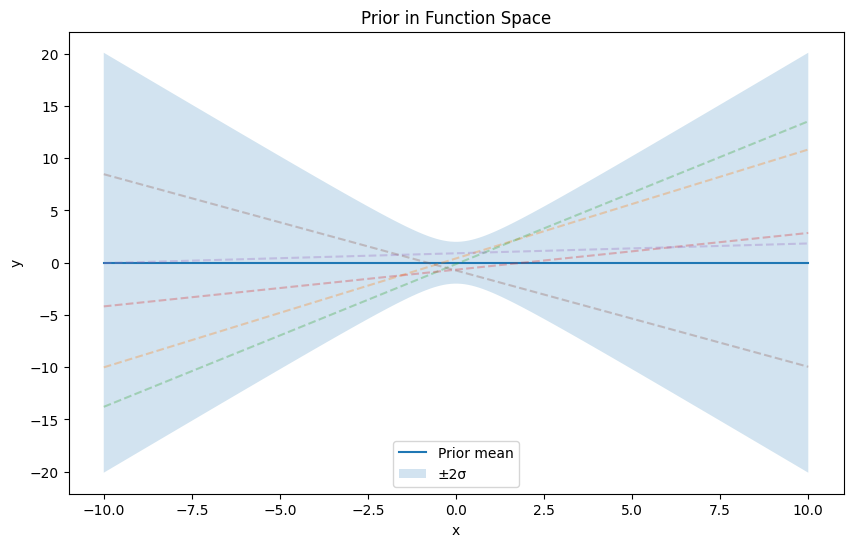

In [18]:
x_grid = np.linspace(-10, 10, 200)
X_grid = Phi(x_grid)
plot_function_space_distribution(mu, Sigma, x_grid, X_grid, 'Prior mean', 'Prior in Function Space', 'x', 'y', n_samples_fn=5, rng=rng)

# Posterior

The **posterior** is $$p(\mathbf{\theta} \mid \mathbf{y}, \mathbf{X}) = \frac{p(\mathbf{y} \mid \mathbf{\theta}, \mathbf{X}) \, p(\mathbf{\theta})}{p(\mathbf{y} \mid \mathbf{X})}$$

Recall: 
+ Prior $p(\theta)$ is Gaussian
+ Likelihood $p(\mathbf{y} \mid \mathbf{\theta}, \mathbf{X})$ is Gaussian with mean *linear* in $\theta$ and known covariance

**Conjugacy!** By completing the square, we can show that the **posterior is also Gaussian** 😍:

 $$\boxed{p(\mathbf{\theta} \mid \mathbf{y}, \mathbf{X}) = \mathcal{N}(\mathbf{\theta}; \mathbf{\mu}_{\text{post}}, \mathbf{\Sigma}_{\text{post}})} \qquad \text{ where } \, \mathbf{\Sigma}_{\text{post}} = \left(\mathbf{\Sigma}^{-1} + \frac{1}{\sigma^2} \mathbf{X}^\top \mathbf{X}\right)^{-1}, \, \, \mathbf{\mu}_{\text{post}} = \mathbf{\Sigma}_{\text{post}} \left(\mathbf{\Sigma}^{-1} \mathbf{\mu} + \frac{1}{\sigma^2} \mathbf{X}^\top \mathbf{y}\right)$$

In [19]:
# Posterior is Gaussian due to conjugacy
Sigma_post = np.linalg.inv(Sigma_inv + 1/sigma_sq * (X.T @ X))
mu_post = Sigma_post @ (Sigma_inv @ mu + 1/sigma_sq * X.T @ y)

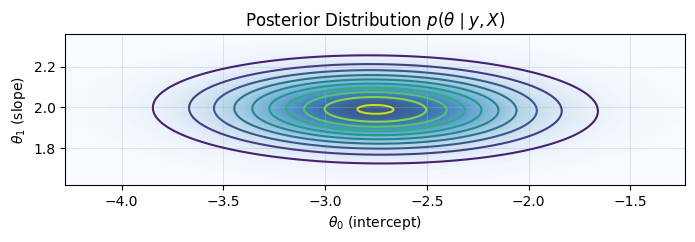

In [20]:
plot_gaussian_pdf(mu_post, Sigma_post, r'$\theta_0$ (intercept)', r'$\theta_1$ (slope)', 
                  r'Posterior Distribution $p(\theta \mid y,X)$', show_colorbar=False)

In [21]:
mu_post

array([-2.75311318,  1.99006948])

In [10]:
Sigma_post

array([[ 0.25798898, -0.00197867],
       [-0.00197867,  0.01523266]])

## Question: What happens to the posterior if we increase the prior variance (i.e., make it more uninformative/flat)?

Let's try it out...

## Posterior in Function Space

Again, we just map the posterior $p(\theta \mid \mathbf{y}, \mathbf{X})$ back out via the linear map $\mathbf{X}^*$:

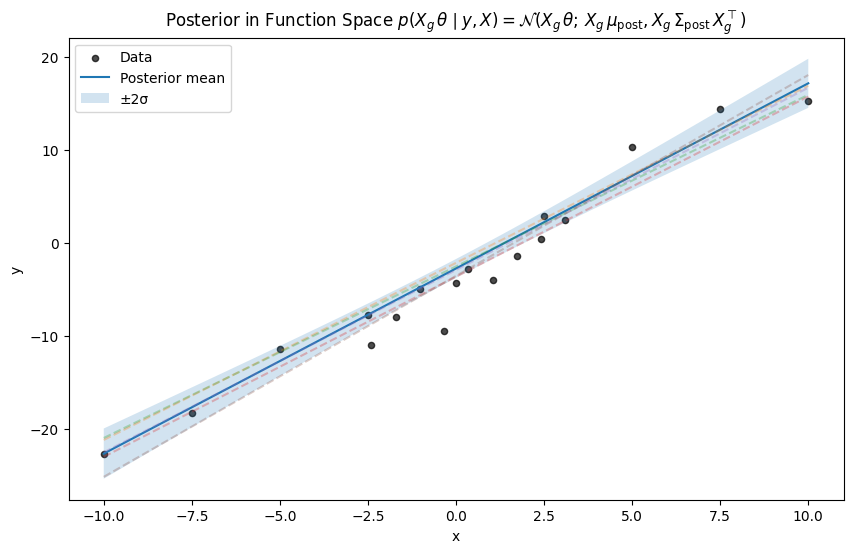

In [25]:
plot_function_space_distribution(mu_post, Sigma_post, x_grid, X_grid, 'Posterior mean', r'Posterior in Function Space $p(X_g \, \theta \mid y, X) = \mathcal{N}(X_g \, \theta; \, X_g \, \mu_{\text{post}}, X_g \, \Sigma_{\text{post}} \, X_g^\top)$',
                                data=(x,y), n_samples_fn=5, rng=rng)

## Posterior Predictive

For **test points** $\mathbf{x}^*_1, \dots \mathbf{x}^*_n$ and with $\mathbf{X}^* := \begin{bmatrix} \phi(\mathbf{x}^*_1) \\ \vdots \\ \phi(\mathbf{x}^*_n) \end{bmatrix}$, $\mathcal{D} := (\mathbf{X}, y)$, the **posterior predictive** is given as
$$ p(y^* \mid \mathbf{X}^*, \mathcal{D}) = \int \underbrace{p(y^* \mid \mathbf{X}^*, \theta)}_{\text{Likelihood}} \, \underbrace{p(\theta \mid \mathcal{D})}_{\text{Posterior}} \, d\theta = \mathcal{N}(y^*; \mathbf{X}^* \mu_{\text{post}}, \, \underbrace{\mathbf{X}^* \Sigma_{\text{post}} (\mathbf{X}^*)^\top}_{\text{Epistemic}} + \underbrace{\sigma^2 I}_{\text{Aleatoric}}) $$

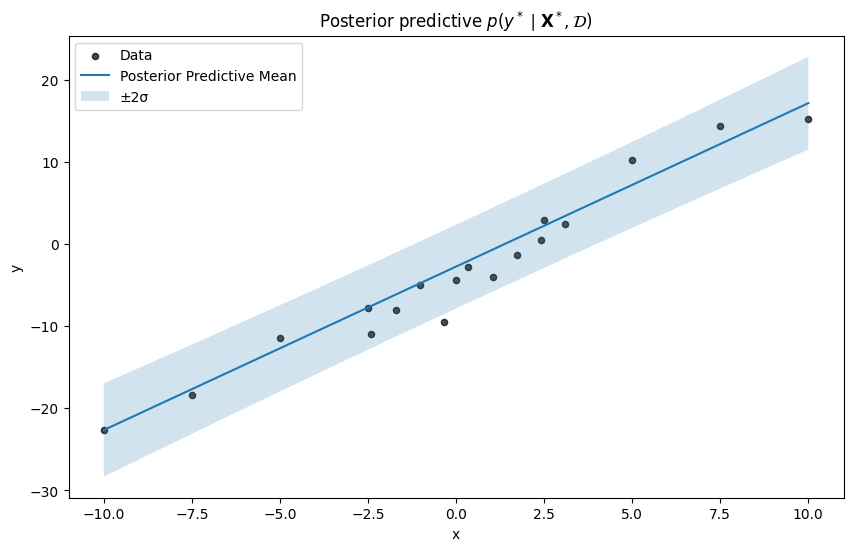

In [26]:
plot_function_space_distribution(mu_post, Sigma_post, x_grid, X_grid, 'Posterior Predictive Mean', r'Posterior predictive $p(y^* \mid \mathbf{X}^*, \mathcal{D})$',
                                data=(x,y), post_pred_sigma_sq=sigma_sq)


## Prior Predictive

Analogously, the **prior predictive** is given as
$$ p(y^* \mid \mathbf{X}^*) = \int \underbrace{p(y^* \mid \mathbf{X}^*, \theta)}_{\text{Likelihood}} \, \underbrace{p(\theta)}_{\text{Prior}} \, d\theta = \mathcal{N}(y^*; \mathbf{X}^* \mu, \, \underbrace{\mathbf{X}^* \Sigma (\mathbf{X}^*)^\top}_{\text{Epistemic}} + \underbrace{\sigma^2 I}_{\text{Aleatoric}}) $$

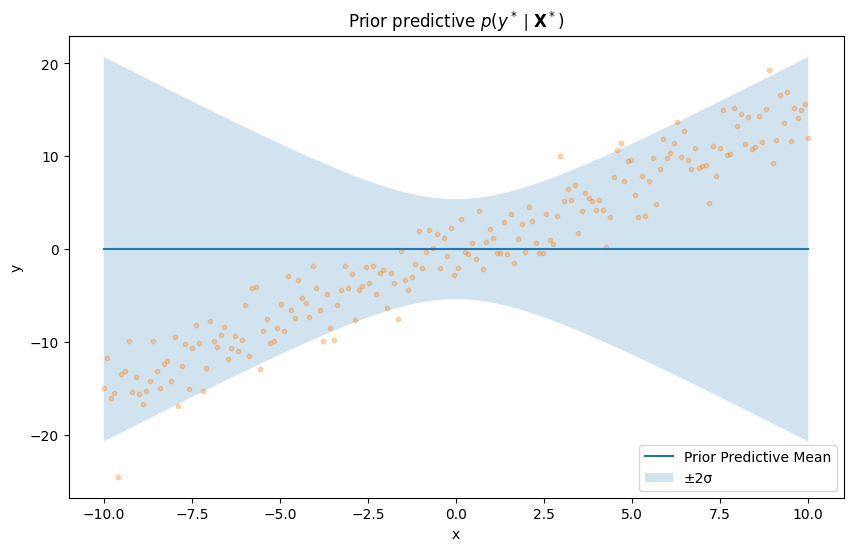

In [ ]:
plot_function_space_distribution(mu, Sigma, x_grid, X_grid, 'Prior Predictive Mean', r'Prior predictive $p(y^* \mid \mathbf{X}^*)$',
                                post_pred_sigma_sq=sigma_sq, n_samples_fn=1, sample_data=True, rng=rng)

## What about datasets non-linear in $x$?

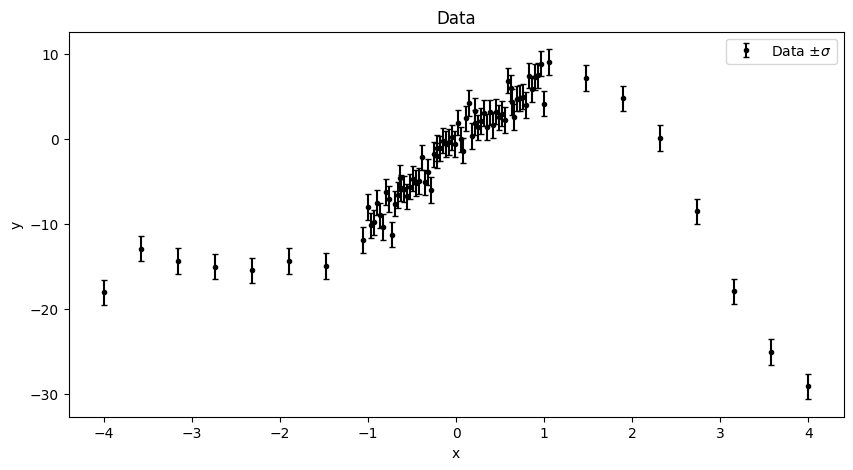

In [30]:
sigma_sq = 1.5**2
x, y = generate_nonlinear_data(N=80, sigma_sq=sigma_sq, rng=rng)

plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=np.sqrt(sigma_sq), fmt='k.', capsize=2, label=r'Data $\pm \sigma$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.legend()
plt.show()

In [31]:
# Feature transformation
def Phi(x):
    """Feature transformation using cosine basis functions."""
    # Create cosine basis features
    # Using multiple frequencies to capture different scales of variation
    features = []
    
    # Bias term
    features.append(np.ones_like(x))
    
    # Cosine basis with different frequencies
    for freq in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        features.append(np.cos(freq * x))
        features.append(np.sin(freq * x))
    
    # Stack features as columns
    return np.column_stack(features)


# Design matrix
X = Phi(x)
X.shape

(80, 13)

In [32]:
# Prior on theta
mu = np.zeros(X.shape[1])     # prior mean on theta
Sigma = np.eye(X.shape[1])    # prior covariance
Sigma_inv = np.linalg.inv(Sigma)

# Posterior is Gaussian due to conjugacy
Sigma_post = np.linalg.inv(Sigma_inv + 1/sigma_sq * (X.T @ X))
mu_post = Sigma_post @ (Sigma_inv @ mu + 1/sigma_sq * X.T @ y)

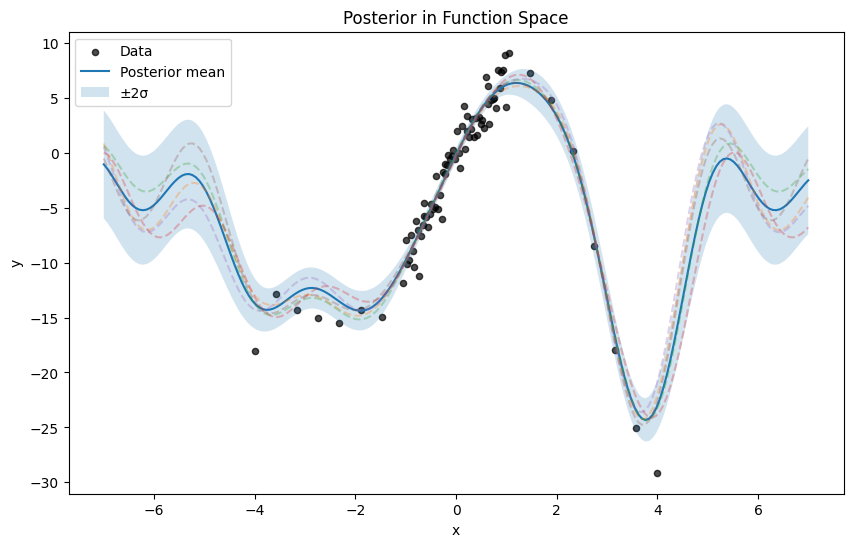

In [34]:
x_grid = np.linspace(-7, 7, 200)
X_grid = Phi(x_grid)
plot_function_space_distribution(mu_post, Sigma_post, x_grid, X_grid, 'Posterior mean', r'Posterior in Function Space',
                                data=(x,y), n_samples_fn=5, rng=rng)

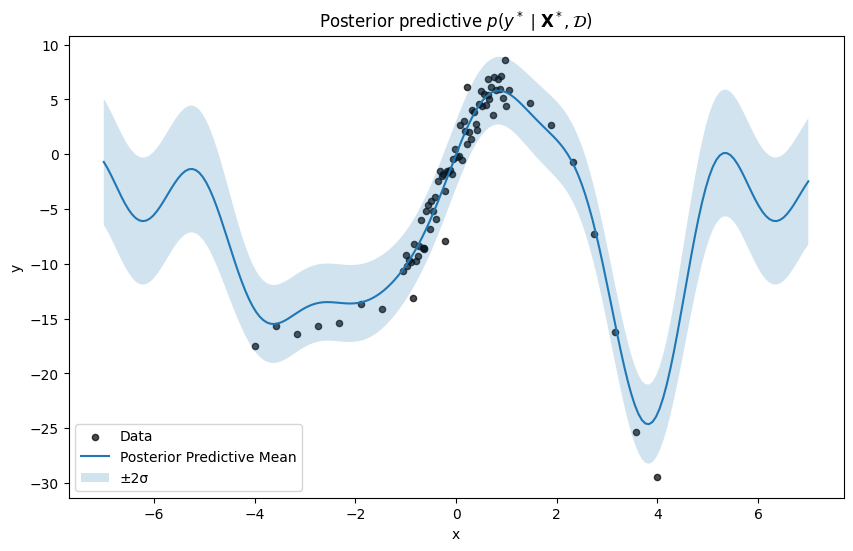

In [603]:
plot_function_space_distribution(mu_post, Sigma_post, x_grid, X_grid, 'Posterior Predictive Mean', r'Posterior predictive $p(y^* \mid \mathbf{X}^*, \mathcal{D})$',
                                data=(x,y), post_pred_sigma_sq=sigma_sq)
